In [24]:
using ModelingToolkit, Sophon, DomainSets
using Optimization, OptimizationOptimJL

@parameters x y
@variables u(..)
Dxx = Differential(x)^2
Dyy = Differential(y)^2

eq = Dxx(u(x, y)) + Dyy(u(x, y)) ~ 0

bcs = [u(-1, y) ~ 1,
       u(1, y) ~ 0,
       u(x, -1) ~ 50/75,
       u(x, 1) ~ 0]


# Space and time domains
domains = [x ∈ Interval(-1.0, 1.0),
           y ∈ Interval(-1.0, 1.0)]

@named pde_system = PDESystem([eq], bcs, domains, [x, y], [u(x, y)])

PDESystem
Equations: Equation[Differential(y)(Differential(y)(u(x, y))) + Differential(x)(Differential(x)(u(x, y))) ~ 0]
Boundary Conditions: Equation[u(-1, y) ~ 1, u(1, y) ~ 0, u(x, -1) ~ 0.6666666666666666, u(x, 1) ~ 0]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(x, -1.0..1.0), Symbolics.VarDomainPairing(y, -1.0..1.0)]
Dependent Variables: Num[u(x, y)]
Independent Variables: Num[x, y]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [25]:
chain = FullyConnected(2, 1, tanh; hidden_dims=20, num_layers=6)
pinn = PINN(chain)
sampler = QuasiRandomSampler(2000, 200)
strategy = NonAdaptiveTraining(1, 10)
prob = Sophon.discretize(pde_system, pinn, sampler, strategy)

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(layer_1 = (weight = [-0.9062318801879883 0.93593430519104; -0.522209644317627 -1.3223326206207275; … ; -1.911845326423645 -1.5321487188339233; -0.43629759550094604 -0.15970802307128906], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [0.6441393494606018 0.10598668456077576 … -0.22159533202648163 0.16871033608913422; -0.3870008587837219 0.5705342292785645 … 0.19368821382522583 0.2766816318035126; … ; 0.46211403608322144 0.3394051790237427 … -0.11117629706859589 -0.16786235570907593; 0.23933613300323486 0.12539352476596832 … -0.3184807002544403 0.01967969723045826], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = [-0.2514708936214447 -0.2421545535326004 … -0.18750989437103271 0.5346493124961853; 0.06382148712873459 0.3718229830265045 … -0.39304691553115845 0.33742737770080566; … ; -0.4117743670940399 0.5693962574005127 … -0.37741729617118835 0.23135127127170563; 0.4032992422580719 -0.3693874776363373 … -0.3

In [36]:
i = 0
function callback(p, l)
    global i
    i%100==0 && println("Loss: $l")
    i += 1
    return false
end

res = Optimization.solve(prob, BFGS(); maxiters=2000, callback=callback)

Loss: 734.0989893362084


Loss: 0.3785919404263631


Loss: 0.11968144957170676


Loss: 0.059358413694380996


Loss: 0.03155885907939477


Loss: 0.014539521230810802


Loss: 0.007760312463794833


Loss: 0.004833956540493397


Loss: 0.0032417798367313055


Loss: 0.0021416508393397207


Loss: 0.0014043252034054796


Loss: 0.0008098521187667289


Loss: 0.00043556073153239226


Loss: 0.0002321848184292987


Loss: 0.00013587036865960166


Loss: 8.1915696718023e-5


Loss: 5.3055959504669294e-5


Loss: 3.3669217158602284e-5


Loss: 2.3486318348791395e-5


Loss: 1.76077310236536e-5


Loss: 1.4034777352670764e-5


u: ComponentVector{Float64}(layer_1 = (weight = [-0.5639580124434974 0.3601248319543343; -0.715888165143828 -0.9773268098908984; … ; -1.0357829454667264 -0.9291812783700334; -0.12409768262401422 -0.47974357451347943], bias = [-0.06695788778749655; -0.13341633596640268; … ; -0.0011798538176191133; -0.25264703124486965;;]), layer_2 = (weight = [0.12981371492868932 -0.5085026128466741 … 0.053892594540053365 0.371643310382684; -0.3596144453142326 1.1066081039672957 … 0.4068214195356995 0.4820856958864252; … ; 0.801974431201174 0.6926836826794095 … -0.28145949446254825 0.14418857035518912; 1.2516171871925734 -0.09231379944744385 … -0.3391526253185619 0.7175022738761561], bias = [-0.34377657312730736; 0.08118389727239911; … ; -0.5294876379158363; 0.3903712615738879;;]), layer_3 = (weight = [-0.19361363366966386 -0.21107442235104362 … -0.1203600952239857 0.7325066655558995; 0.40118734275023255 0.28912673537621125 … 0.11473340886641598 0.8310710161664986; … ; -1.2866619306029483 0.090700375810

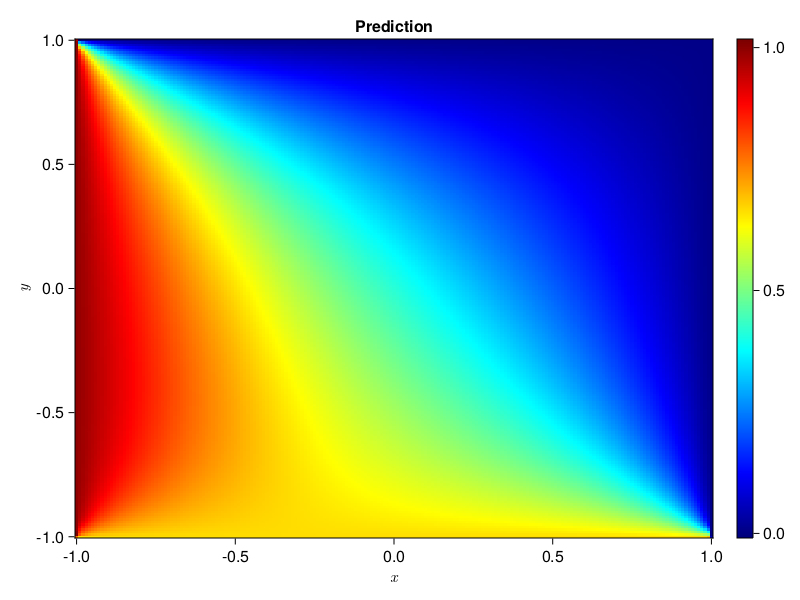

In [37]:
using CairoMakie, MakiePublication

phi = pinn.phi
xs, ys = [infimum(d.domain):0.01:supremum(d.domain) for d in pde_system.domain]
axis = (xlabel=L"x", ylabel=L"y", title="Prediction")
u_pred = [sum(pinn.phi([x, y], res.u)) for x in xs, y in ys]
fig, ax, hm = heatmap(xs, ys, u_pred, axis=axis, colormap=:jet)
Colorbar(fig[1,2], hm)
fig